In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score
pd.set_option('max_colwidth', 100)

In [2]:
from mixedvines.copula import GaussianCopula
from mixedvines.mixedvine import MixedVine
from scipy.stats import norm, bernoulli
import itertools

rng = np.random.default_rng()

In [3]:
'''def gen_auc_boots(scores, truth, nboots=100, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    boot_res = []
    for pp in range(nboots):
        boot_ind = rng.choice(range(len(truth)), size=truth.size, replace=True)
        boot_truth = truth[boot_ind]
        boot_score = scores[boot_ind]
        boot_res.append(roc_auc_score(boot_truth, boot_score))
    return np.array(boot_res)'''

def gen_auc_boots(scores, truth, nboots=100, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    boot_res = []
    for pp in range(nboots):
        boot_ind = rng.choice(range(len(truth)), size=truth.size, replace=True)
        boot_truth = truth[boot_ind]
        boot_score = scores[boot_ind]
        while len(np.unique(boot_truth)) == 1:
            boot_ind = rng.choice(range(len(truth)), size=truth.size, replace=True)
            boot_truth = truth[boot_ind]
            boot_score = scores[boot_ind]
        boot_res.append(roc_auc_score(boot_truth, boot_score))
    return np.array(boot_res)

In [4]:
alpha = 0.05

In [15]:
population_size = 100000
sample_size = 300
case_rate = 0.10
target_auc = 0.8
dim=2
corrs = rng.uniform(size=500)
sim_res = []
for cix, corr in enumerate(corrs):
    vine = MixedVine(dim)
    vine.set_marginal(0, norm(0,1))
    vine.set_marginal(1, bernoulli(case_rate))
    vine.set_copula(1, 0, GaussianCopula(corr))
    population = vine.rvs(population_size)
    pop_y_score = population[:, 0]
    pop_y_true = population[:, 1]
    pop_auc = roc_auc_score(pop_y_true, pop_y_score)
    samples = rng.choice(population, size=sample_size, replace=False)
    samp_y_score = samples[:,0]
    samp_y_true = samples[:,1]
    samp_auc = roc_auc_score(samp_y_true, samp_y_score)
    boots = gen_auc_boots(samp_y_score, samp_y_true, nboots=1000, rng=rng)
    boots = np.hstack([boots, np.array([samp_auc])])
    p = (boots >= target_auc).mean()
    row = {}
    row['sim_ix'] = cix
    row['corr'] = corr
    row['pop_case_rate'] = pop_y_true.mean()
    row['pop_auc'] = pop_auc
    row['samp_case_rate'] = samp_y_true.mean()
    row['samp_auc'] = samp_auc
    row['samp_p'] = p
    sim_res.append(row)
sim_res = pd.DataFrame(sim_res)

ValueError: parameter theta out of bounds

In [69]:
while True:
    try:
        population_size = 100000
        sample_size = 197
        case_rate = 0.60
        target_auc = 0.8
        dim=2
        corrs = rng.uniform(size=500)
        sim_res = []
        for cix, corr in enumerate(corrs):
            vine = MixedVine(dim)
            vine.set_marginal(0, norm(0,1))
            vine.set_marginal(1, bernoulli(case_rate))
            vine.set_copula(1, 0, GaussianCopula(corr))
            population = vine.rvs(population_size)
            pop_y_score = population[:, 0]
            pop_y_true = population[:, 1]
            pop_auc = roc_auc_score(pop_y_true, pop_y_score)
            samples = rng.choice(population, size=sample_size, replace=False)
            samp_y_score = samples[:,0]
            samp_y_true = samples[:,1]
            samp_auc = roc_auc_score(samp_y_true, samp_y_score)
            boots = gen_auc_boots(samp_y_score, samp_y_true, nboots=1000, rng=rng)
            boots = np.hstack([boots, np.array([samp_auc])])
            p = (boots >= target_auc).mean()
            row = {}
            row['sim_ix'] = cix
            row['corr'] = corr
            row['pop_case_rate'] = pop_y_true.mean()
            row['pop_auc'] = pop_auc
            row['samp_case_rate'] = samp_y_true.mean()
            row['samp_auc'] = samp_auc
            row['samp_p'] = p
            sim_res.append(row)
        sim_res = pd.DataFrame(sim_res)
    except:
         continue
    else:
         break

In [64]:
# calculate cumulative power
sim_res['sig'] = sim_res.samp_p < alpha
sim_res['dummy'] = 1
sim_res = sim_res.sort_values('pop_auc').reset_index(drop=True)
sim_res['cumulative_power'] = sim_res.sig.cumsum()/sim_res.dummy.cumsum()


In [65]:
sim_res

,sim_ix,corr,pop_case_rate,pop_auc,samp_case_rate,samp_auc,samp_p,sig,dummy,cumulative_power
0,311,0.008351,0.10006,0.496980,0.098402,0.516042,0.0,True,1,1.000000
1,0,0.000475,0.10017,0.498178,0.106812,0.564579,0.0,True,1,1.000000
2,306,0.007738,0.09967,0.503043,0.113541,0.477869,0.0,True,1,1.000000
3,154,0.016403,0.09949,0.504426,0.109336,0.452597,0.0,True,1,1.000000
4,399,0.001476,0.09997,0.504738,0.095038,0.504038,0.0,True,1,1.000000
...,...,...,...,...,...,...,...,...,...,...
495,474,0.991252,0.09970,0.997083,0.111018,0.998352,1.0,False,1,0.477823
496,436,0.991960,0.10046,0.997134,0.104289,0.995722,1.0,False,1,0.476861
497,45,0.992274,0.09946,0.997196,0.091674,0.997256,1.0,False,1,0.475904
498,113,0.993486,0.10119,0.997714,0.097561,0.998465,1.0,False,1,0.474950


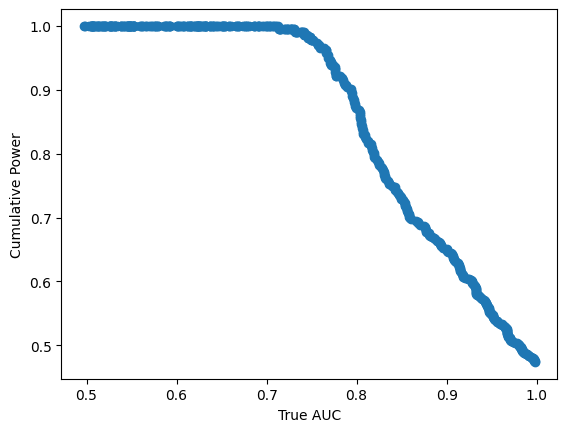

In [66]:
fig,ax = plt.subplots(1)
plt.plot(sim_res.pop_auc, sim_res.cumulative_power, 'o')
ax.set_xlabel('True AUC')
ax.set_ylabel('Cumulative Power')
fig.set_facecolor('white')

In [67]:
sim_res.query('cumulative_power >= 0.8').sort_values('cumulative_power')

,sim_ix,corr,pop_case_rate,pop_auc,samp_case_rate,samp_auc,samp_p,sig,dummy,cumulative_power
295,177,0.596154,0.09903,0.818834,0.082422,0.823276,0.879121,False,1,0.800676
294,111,0.591397,0.10034,0.818528,0.095038,0.836777,0.978022,False,1,0.803390
293,287,0.594462,0.09939,0.817333,0.085786,0.826235,0.900100,False,1,0.806122
292,429,0.586070,0.10134,0.817298,0.110177,0.856463,1.000000,False,1,0.808874
291,476,0.573988,0.09857,0.816322,0.081581,0.808117,0.655345,False,1,0.811644
...,...,...,...,...,...,...,...,...,...,...
95,224,0.173907,0.09960,0.600963,0.112700,0.573233,0.000000,True,1,1.000000
94,392,0.186834,0.10004,0.600961,0.111018,0.619098,0.000000,True,1,1.000000
93,198,0.165860,0.10041,0.593123,0.096720,0.576812,0.000000,True,1,1.000000
109,441,0.212177,0.10076,0.615979,0.102607,0.611628,0.000000,True,1,1.000000


In [68]:
sim_res.query('pop_auc >= 0.7999').sort_values('cumulative_power')

,sim_ix,corr,pop_case_rate,pop_auc,samp_case_rate,samp_auc,samp_p,sig,dummy,cumulative_power
499,491,0.993892,0.10058,0.997866,0.116064,0.997656,1.000000,False,1,0.474000
498,113,0.993486,0.10119,0.997714,0.097561,0.998465,1.000000,False,1,0.474950
497,45,0.992274,0.09946,0.997196,0.091674,0.997256,1.000000,False,1,0.475904
496,436,0.991960,0.10046,0.997134,0.104289,0.995722,1.000000,False,1,0.476861
495,474,0.991252,0.09970,0.997083,0.111018,0.998352,1.000000,False,1,0.477823
...,...,...,...,...,...,...,...,...,...,...
276,232,0.565389,0.09963,0.804287,0.084945,0.776363,0.145854,False,1,0.855596
275,465,0.561080,0.10074,0.804181,0.102607,0.800674,0.511489,False,1,0.858696
274,377,0.561471,0.09818,0.804149,0.104289,0.769749,0.068931,False,1,0.861818
273,132,0.571204,0.09886,0.804019,0.103448,0.835682,0.978022,False,1,0.864964


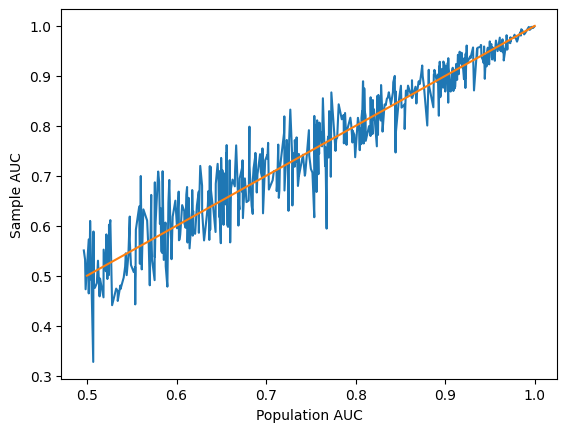

In [14]:
# make sure there's not a bias for sample AUC relative to population AUC
fig, ax = plt.subplots(1)
ax.plot(sim_res.pop_auc, sim_res.samp_auc)
ax.plot([0.5,1], [0.5,1])
ax.set_xlabel('Population AUC')
ax.set_ylabel('Sample AUC')
fig.set_facecolor('white')